
# Autômato Celular 2D: Competição entre Espécies

Este notebook simula a dinâmica de duas espécies (azul e vermelha) interagindo em um ambiente 2D utilizando um autômato celular. O sistema inclui reprodução, movimentação e predação entre espécies, com análise visual e quantitativa da evolução temporal.



## Descrição do Sistema

- O ambiente é uma grade 2D de tamanho $N \times N$.
- Cada célula pode estar vazia (0), conter um indivíduo **azul** (+1), ou um indivíduo **vermelho** (-1).
- As populações iniciais são de:
  - $n_a$ indivíduos azuis
  - $n_v$ indivíduos vermelhos
  - Com $n_a + n_v < N^2 / 3$ para garantir espaço livre

### Regras de Evolução

1. **Movimento Aleatório**:
   - Cada indivíduo pode se mover para uma célula vizinha (cima, baixo, esquerda, direita) se ela estiver vazia.

2. **Reprodução**:
   - Se dois indivíduos da **mesma espécie** estão adjacentes, então com probabilidade `tn_a` ou `tn_v`, um novo indivíduo da mesma espécie nasce em uma célula aleatória vazia.

3. **Predação**:
   - Se indivíduos de espécies **distintas** estão adjacentes, o **vermelho** é aniquilado com probabilidade `p_a`.

4. **Mortalidade por Fome (Azul)**:
   - Um azul que passar `tau` passos sem encontrar um vermelho vizinho morre com probabilidade `pm_a`.


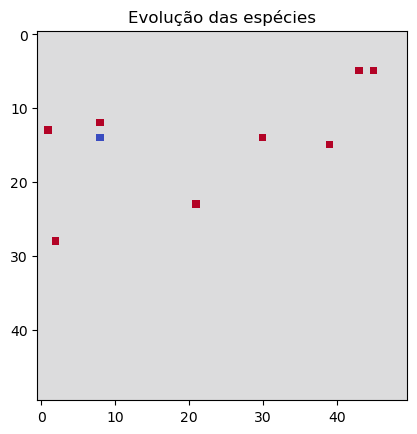

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Parâmetros do sistema
N = 50               # Tamanho da grade NxN
n_a = 100              # População inicial azul
n_v = 100            # População inicial vermelha
tn_a = 0.01          # Taxa de nascimento azul
tn_v = 0.02           # Taxa de nascimento vermelha
p_a = 0.5            # Probabilidade de predação azul -> vermelho
pm_a = 0.01            # Probabilidade de morte por fome
tau = 10              # Passos até azul morrer de fome
steps = 500          # Número de passos de simulação

# Códigos das células
EMPTY, AZUL, VERMELHO = 0, 1, -1

# Inicialização da rede e da matriz de "fome"
rede = np.zeros((N, N), dtype=int)
fome_azul = np.zeros((N, N), dtype=int)

# Distribuição inicial aleatória
posicoes = np.random.permutation(N * N)
coords = np.array([(p // N, p % N) for p in posicoes])
for i in range(n_a):
    x, y = coords[i]
    rede[x, y] = AZUL
for i in range(n_a, n_a + n_v):
    x, y = coords[i]
    rede[x, y] = VERMELHO

# Funções auxiliares
def vizinhos(x, y):
    return [(x+dx, y+dy) for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)] if 0 <= x+dx < N and 0 <= y+dy < N]

def celulas_vazias(matriz):
    return list(zip(*np.where(matriz == EMPTY)))

# Histórico das populações
hist_azul = []
hist_vermelho = []

# Setup para animação
fig, ax = plt.subplots()
img = ax.imshow(rede, cmap='coolwarm_r', vmin=-1, vmax=1)
ax.set_title("Evolução das espécies")

def update(frame):
    global rede, fome_azul
    nova_rede = np.zeros_like(rede)
    nova_fome = np.zeros_like(fome_azul)
    ocupada = np.zeros((N, N), dtype=bool)

    # --- Movimento (com buffer para evitar sobrescrita) ---
    movimentos = []
    for x in range(N):
        for y in range(N):
            if rede[x, y] != EMPTY:
                np.random.shuffle(viz := vizinhos(x, y))
                for xn, yn in viz:
                    if rede[xn, yn] == EMPTY and not ocupada[xn, yn]:
                        movimentos.append((x, y, xn, yn))
                        ocupada[xn, yn] = True
                        break
                else:
                    ocupada[x, y] = True

    # Aplicar movimentos
    for x_old, y_old, x_new, y_new in movimentos:
        especie = rede[x_old, y_old]
        nova_rede[x_new, y_new] = especie
        if especie == AZUL:
            nova_fome[x_new, y_new] = fome_azul[x_old, y_old] + 1
    # Para quem não se moveu
    for x in range(N):
        for y in range(N):
            if not nova_rede[x, y] and ocupada[x, y]:
                nova_rede[x, y] = rede[x, y]
                if rede[x, y] == AZUL:
                    nova_fome[x, y] = fome_azul[x, y]

    # --- Reprodução ---
    for x in range(N):
        for y in range(N):
            especie = nova_rede[x, y]
            if especie in [AZUL, VERMELHO]:
                for xn, yn in vizinhos(x, y):
                    if nova_rede[xn, yn] == especie:
                        if especie == AZUL and np.random.rand() < tn_a:
                            livres = celulas_vazias(nova_rede)
                            if livres:
                                xnv, ynv = livres[np.random.randint(len(livres))]
                                nova_rede[xnv, ynv] = AZUL
                        elif especie == VERMELHO and np.random.rand() < tn_v:
                            livres = celulas_vazias(nova_rede)
                            if livres:
                                xnv, ynv = livres[np.random.randint(len(livres))]
                                nova_rede[xnv, ynv] = VERMELHO

    # --- Fome dos azuis ---
    for x in range(N):
        for y in range(N):
            if nova_rede[x, y] == AZUL:
                if any(nova_rede[xn, yn] == VERMELHO for xn, yn in vizinhos(x, y)):
                    nova_fome[x, y] = 0
                elif nova_fome[x, y] >= tau and np.random.rand() < pm_a:
                    nova_rede[x, y] = EMPTY
                    nova_fome[x, y] = 0

    # --- Predação (azul mata vermelho) ---
    for x in range(N):
        for y in range(N):
            if nova_rede[x, y] == AZUL:
                for xn, yn in vizinhos(x, y):
                    if nova_rede[xn, yn] == VERMELHO and np.random.rand() < p_a:
                        nova_rede[xn, yn] = EMPTY

    # Atualizar estado global
    rede[:] = nova_rede
    fome_azul[:] = nova_fome
    hist_azul.append(np.sum(rede == AZUL))
    hist_vermelho.append(np.sum(rede == VERMELHO))
    img.set_data(rede)
    return [img]

# Criar animação
ani = animation.FuncAnimation(fig, update, frames=steps, blit=True)
HTML(ani.to_html5_video())


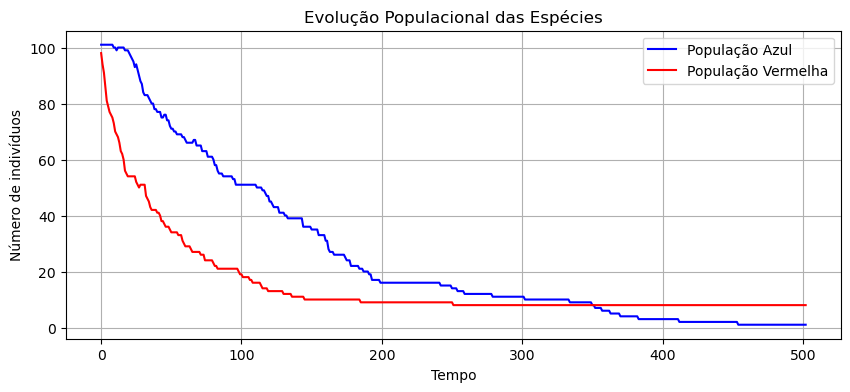

In [28]:

# Gráfico das populações ao longo do tempo
plt.figure(figsize=(10, 4))
plt.plot(hist_azul, label="População Azul", color='blue')
plt.plot(hist_vermelho, label="População Vermelha", color='red')
plt.xlabel("Tempo")
plt.ylabel("Número de indivíduos")
plt.legend()
plt.title("Evolução Populacional das Espécies")
plt.grid(True)

plt.show()
